In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

/home/irobotics/anaconda3/envs/octo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Path definitions

In [2]:
PATH_CHECKPOINTS = "/media/irobotics/Transcend/finetuned_checkpoints/v5_delta_checkpoints/"
PATH_DATASET_TFDS = '/media/irobotics/Transcend/tensorflow_datasets/v5_test_delta/example_dataset/1.0.0/'
PATH_INFERENCE_RESULTS = "/media/irobotics/Transcend/inference_result/"

2. Load checkpoints

In [3]:
from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained(PATH_CHECKPOINTS)

2024-10-22 14:35:47.178282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 14:35:47.178335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 14:35:47.203158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 14:35:47.921453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/irobotics/anaconda3/envs/octo/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in

3. Read test rlds datasets

In [4]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir=PATH_DATASET_TFDS)
ds = builder.as_dataset(split='train[:3]')
iterator = iter(ds)

2024-10-22 14:36:40.031203: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
episode = next(iterator)
episode

{'episode_metadata': {'file_path': <tf.Tensor: shape=(), dtype=string, numpy=b'data/train/episode_2.npy'>},
 'steps': <_VariantDataset element_spec={'action': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': {'image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), 'state': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'wrist_image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}

In [6]:
# sample episode + resize to 256x256 (default third-person cam resolution)
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
images_wrist = [cv2.resize(np.array(step['observation']['wrist_image']), (256, 256)) for step in steps]

# # add zero-padding in the beginning to images
# images = [np.zeros_like(images[0])] + images
# images_wrist = [np.zeros_like(images_wrist[0])] + images_wrist


# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[10]['language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=1)

Instruction: active block selected: YellowCube


4. Run Inference

In [7]:
WINDOW_SIZE = 2

# create `task` dict
# task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(goals={"image_primary": goal_image})
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [29]:
WINDOW_SIZE = 1

In [14]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
### modified ###    
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
# for step in tqdm.trange(len(images)):
### modified ###

    ### modified ###
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    input_images_wrist = np.stack(images_wrist[step:step+WINDOW_SIZE])[None]
    # input_images = np.stack(images[step])[None][None]
    # input_images_wrist = np.stack(images_wrist[step])[None][None]

    ### modified ###
    observation = {
        'image_primary': input_images,
        'image_wrist': input_images_wrist,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim

    pred_actions.append(actions)
    ### modified ###
    final_window_step = step + WINDOW_SIZE - 1
    # final_window_step = step
    ### modified ###
    true_actions.append(
        steps[final_window_step-1]['action']
    )

100%|██████████| 19/19 [01:02<00:00,  3.29s/it]


5. Visualize results

In [15]:
# calculate mean squared error
pred_actions = np.stack(pred_actions)
true_actions = np.stack(true_actions)
mse = np.mean((pred_actions[:,0,:] - true_actions) ** 2)
nomralized_mse = mse / (np.max(true_actions)-np.min(true_actions)) ** 2
print(f'Normalized Mean Squared Error: {nomralized_mse}')

Normalized Mean Squared Error: 0.006929838564246893


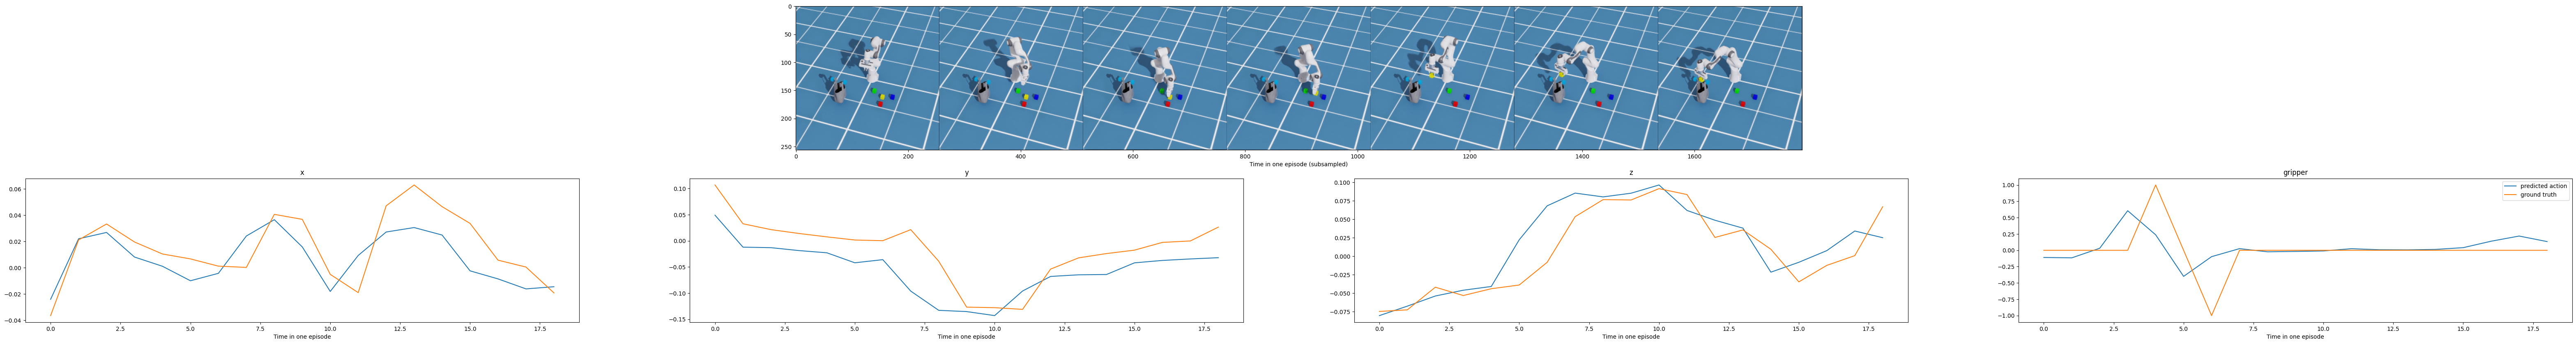

In [16]:
import matplotlib.pyplot as plt

# ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp', "aa", "bb"]
ACTION_DIM_LABELS = ['x', 'y', 'z', 'gripper']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
    # [label] for label in ACTION_DIM_LABELS
]
# plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([80, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, action_dim shape
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()

In [11]:
# print(pred_actions[:, 0, :])

In [12]:
# print(true_actions)

6. Save actions numpy files

In [14]:
np.save(PATH_INFERENCE_RESULTS + "v5_delta_pred_actions.npy", pred_actions[:, 0, :])

In [13]:
np.save(PATH_INFERENCE_RESULTS + "v5_delta_true_actions.npy", true_actions)